**Function 6:** 

Cake and Stuff. Time to get cooking! You are optimising a cake recipe. There are five ingredients. The outputs correspond to the sum of different objectives: flavor, consistency, calories, waste and cost. Each objective receives negative points by our expert taster. You want this sum to be as close to zero as possible!

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
f6_inputs = np.load("initial_inputs.npy")
f6_outputs = np.load("initial_outputs.npy")
f6_inputs_2 = np.load("initial_inputs2.npy")
f6_outputs_2 = np.load("initial_outputs2.npy")

In [11]:
f6_inputs = np.concatenate((f6_inputs, f6_inputs_2)) 
f6_inputs = np.concatenate((f6_inputs, np.array([[0.345535, 0.754647, 0.491966, 0.450836, 0.604032]]))) 
f6_inputs = np.concatenate((f6_inputs, np.array([[0.853367, 0.617629, 0.937563, 0.301578, 0.415393]]))) 
f6_inputs = np.concatenate((f6_inputs, np.array([[0.688186, 0.184692, 0.772551, 0.691116, 0.066401]]))) 
f6_inputs = np.concatenate((f6_inputs, np.array([[0.622911, 0.51695 , 0.236728, 0.47113 , 0.706154]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.668186, 0.204692, 0.792551, 0.711116, 0.086401]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.648186, 0.224692, 0.812551, 0.691116, 0.066401]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.648186, 0.184692, 0.812551, 0.731116, 0.106401]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.628186, 0.164692, 0.792551, 0.751116, 0.126401]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.668186, 0.204692, 0.832551, 0.751116, 0.126401]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.381006, 0.349024, 0.584465, 0.808867, 0.155764]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.427005, 0.337664, 0.600496, 0.733667, 0.176168]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.363984, 0.316227, 0.577013, 0.689438, 0.077835]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.459871, 0.365921, 0.606441, 0.783317, 0.239875]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.447005, 0.317664, 0.620496, 0.713667, 0.196168]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.435998, 0.406845, 0.668405, 0.811834, 0.130345]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.45466 , 0.346872, 0.657419, 0.858968, 0.11944]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.458766, 0.303592, 0.663674, 0.996131, 0.076816]])))
f6_inputs = np.concatenate((f6_inputs, np.array([[0.384916, 0.311188, 0.757855, 0.803686, 0.13494 ]])))

f6_outputs = np.concatenate((f6_outputs,f6_outputs_2)) 
f6_outputs = np.append(f6_outputs,-1.5810999457962531)
f6_outputs = np.append(f6_outputs,-1.8787437904480868)
f6_outputs = np.append(f6_outputs,-0.6247687161411921)
f6_outputs = np.append(f6_outputs,-1.718806647852857)
f6_outputs = np.append(f6_outputs,-0.5671773346921368)
f6_outputs = np.append(f6_outputs,-0.5874063902941494)
f6_outputs = np.append(f6_outputs,-0.5144914715079646)
f6_outputs = np.append(f6_outputs,-0.5415990286820394)
f6_outputs = np.append(f6_outputs,-0.5996653040294271)
f6_outputs = np.append(f6_outputs,-0.22072442707678375)
f6_outputs = np.append(f6_outputs,-0.18264958158407013)
f6_outputs = np.append(f6_outputs,-0.3440970432570667)
f6_outputs = np.append(f6_outputs,-0.23533067806486813)
f6_outputs = np.append(f6_outputs,-0.2639220819499121)
f6_outputs = np.append(f6_outputs,-0.17148052911247116)
f6_outputs = np.append(f6_outputs,-0.06247688853060665)
f6_outputs = np.append(f6_outputs,-0.4406374095498452)
f6_outputs = np.append(f6_outputs,-0.2633675699383991)


In [12]:
X_max= f6_inputs[np.argmax((f6_outputs))]
print(X_max)

[0.45466  0.346872 0.657419 0.858968 0.11944 ]


In [13]:
Y_max= f6_outputs[np.argmax((f6_outputs))]
print(Y_max)

-0.06247688853060665


In [16]:
def costly_function(x):
    total = np.array([])
    for x_i in x:
         total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    
    return total  + np.random.randn()

In [17]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
    
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            
            #for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
            for x_start in np.random.uniform(low=0.1, high=0.99, size=(1,5)):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                if response.fun < min_ei:
                    min_ei = response.fun
                    x_optimal = response.x
            
            return x_optimal, min_ei
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
        
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                 prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            tmpdf = pd.DataFrame({"y": y_max, "ei": optimal_ei},index=[1])
            #self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
            self.best_samples_ =pd.concat([self.best_samples_ ,tmpdf],ignore_index = True)
        
        return optimal_x, y_max
  
  
        

In [18]:
sample_x = f6_inputs
sample_y = f6_outputs

In [17]:
bopt = BayesianOptimizer(target_func=costly_function, x_init=sample_x, y_init=sample_y, n_iter=299, scale=5, batch_size=20)
bopt.optimize()

(array([0.97686171, 0.70138869, 0.7948427 , 0.22768739, 0.33155569]),
 1.99912154527626)

In [15]:
#(array([0.62291153, 0.51695057, 0.23672867, 0.47113001, 0.70615486]),2.2680212028489284)
#(array([0.1362315 , 0.2845422 , 0.64610313, 0.84893393, 0.25951708]),2.8455887885328073)
#(array([ 1.25600116,  0.9137038 ,  0.34016746, -0.68031218,  0.49133008]),2.61048582184561)
#(array([ 1.76755827,  1.36262605, -0.00312259,  0.40142732,  0.36652603]),3.039603674088104)

In [19]:
f6_inputs

array([[7.28186105e-01, 1.54692570e-01, 7.32551669e-01, 6.93996509e-01,
        5.64013105e-02],
       [2.42384347e-01, 8.44099972e-01, 5.77809099e-01, 6.79021284e-01,
        5.01952888e-01],
       [7.29522610e-01, 7.48106200e-01, 6.79774641e-01, 3.56552279e-01,
        6.71053683e-01],
       [7.70620242e-01, 1.14403744e-01, 4.67799319e-02, 6.48324285e-01,
        2.73549053e-01],
       [6.18812299e-01, 3.31802137e-01, 1.87287868e-01, 7.56238474e-01,
        3.28834798e-01],
       [7.84958094e-01, 9.10682349e-01, 7.08120104e-01, 9.59225429e-01,
        4.91149586e-03],
       [1.45110786e-01, 8.96684598e-01, 8.96322235e-01, 7.26271537e-01,
        2.36271991e-01],
       [9.45069068e-01, 2.88459051e-01, 9.78805764e-01, 9.61655587e-01,
        5.98015936e-01],
       [1.25720155e-01, 8.62724692e-01, 2.85443322e-02, 2.46605272e-01,
        7.51206241e-01],
       [7.57594355e-01, 3.55831415e-01, 1.65228997e-02, 4.34207205e-01,
        1.12433044e-01],
       [5.36796903e-01, 3.0878

In [20]:
f6_outputs

array([-0.71426495, -1.20995524, -1.67219994, -1.53605771, -0.82923655,
       -1.24704893, -1.23378638, -1.69434344, -2.57116963, -1.30911635,
       -1.14478485, -1.91267714, -1.62283895, -1.35668211, -2.0184254 ,
       -1.70255784, -1.29424696, -0.93575656, -2.15576776, -1.74688209,
       -1.51269542, -1.34959856, -1.82739562, -1.71602331, -0.97248425,
       -1.20521138, -1.10099104, -1.91309535, -1.05157417, -1.19458833,
       -2.06906505, -1.48937327, -1.82528398, -1.7476171 , -1.35823203,
       -1.44913772, -1.81134837, -2.00771782, -0.99967761, -1.67533648,
       -1.58109995, -1.87874379, -0.62476872, -1.71880665, -0.56717733,
       -0.58740639, -0.51449147, -0.54159903, -0.5996653 , -0.22072443,
       -0.18264958, -0.34409704, -0.23533068, -0.26392208, -0.17148053,
       -0.06247689, -1.51269542, -1.34959856, -1.82739562, -1.71602331,
       -0.97248425, -1.20521138, -1.10099104, -1.91309535, -1.05157417,
       -1.19458833, -2.06906505, -1.48937327, -1.82528398, -1.74

In [18]:
f5_outputs = np.load("initial_outputs.npy")

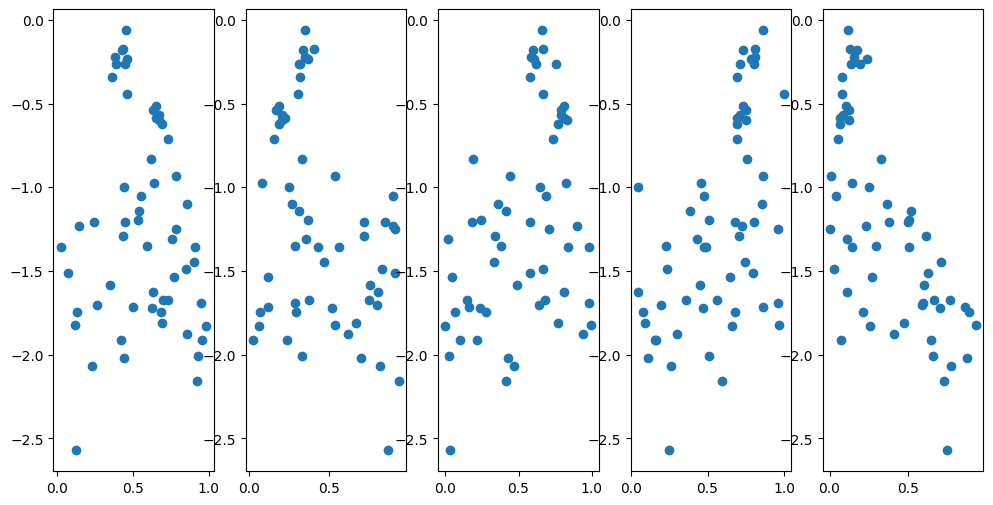

In [14]:
fig, ax = plt.subplots(1,5,figsize = (12,6))
ax[0].scatter(f6_inputs[:,0],f6_outputs)
ax[1].scatter(f6_inputs[:,1],f6_outputs)
ax[2].scatter(f6_inputs[:,2],f6_outputs)
ax[3].scatter(f6_inputs[:,3],f6_outputs)
ax[4].scatter(f6_inputs[:,4],f6_outputs)
plt.show()